In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import SubpopulationsLib.DataProcessing as dp
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import scipy as sp
from SubpopulationsLib.Subpopulations import find_theta_sa
from SubpopulationsLib.Subpopulations import mixture_exponentials, mixture_SIR
from SubpopulationsLib.Metrics import MAPE
from sklearn.linear_model import RidgeCV
from SubpopulationsLib.InfectiousModels import SIR
from SubpopulationsLib.Learners import MarkovChainRNN
from keras_preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# function to read data from a csv file
def read_data(filename, start_date, end_date, country):

    # get SIR data from the specified file
    S,I,R = dp.create_SIR_data(country, filename, '../Data/UID_ISO_FIPS_LookUp_Table.csv', start_date, end_date)
    
    # create indices to put data into a weekly format
    indexes_weekly = np.arange(0,S.shape[0],7)

    # use the indices to get weekly data
    S = S[indexes_weekly]
    I = I[indexes_weekly]
    R = R[indexes_weekly]

    # get rid of the first element of the data
    #data = I[1:]

    return [S, I, R]


# function to create a plot with a given data set
def plot_data(data, country,title="# of infected people over time in ",x_label="# infected",y_label="time (weeks)"):

    #create a figure
    plt.figure()

    #plot the data
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title + country)

    return plt

# function to find and return peaks in data
def get_peaks(data,smoothing_alg=sp.signal.savgol_filter,peak_alg=sp.signal.find_peaks):

    # filter used to smooth the data 
    # for more info on filter, look at https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    smoothed_data =  smoothing_alg(data, len(data)//2,3)

    # finds the peaks in the smoothed data
    # uses neighbouring data in dataset to determine local maxima, which are considered peaks
    peaks = peak_alg(smoothed_data)[0]

    return peaks, len(peaks)


def fit_sir_model(data, num_peaks):

    # bounds that are used for the SIR model
    bound_S = (0,1E8)
    bound_beta = (0,1)
    bound_gamma = (0,1)
    bound_coef = (0,1000)
    bound_k = (0,50)
    bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]
 
    return fit_model(data,num_peaks,bound_list_SIR,"SIR")[1]

# function to fit a guassian distribution to the data
def fit_gaussian_model(data, num_peaks):

    # bounds that are used for the Gaussian model
    bounds_mu = (0,50)
    bounds_sigma = (1,6)
    bounds_coef = (0,300000)
    bound_list_Gaussian = [bounds_mu,bounds_sigma,bounds_coef]
    
    return fit_model(data,num_peaks,bound_list_Gaussian,"Gaussian")[1]


# function to fit data to different model types
def fit_model(data,num_mixtures,bound_list=[],model_type="SIR"):

    # get subpopulations in data
    # mixtures, num_mixtures = get_peaks(data)

    # make sure the bound list is not empty
    if len(bound_list) != 0:
        
        # create the list of bounds with repeated values
        # this is faster than nested for loops
        # code used is from https://stackoverflow.com/a/24225372
        bounds = list(itertools.chain.from_iterable(itertools.repeat(i,num_mixtures) for i in bound_list))

    bias = np.min(data)
    norm_I = data - bias

    # check which model will be used
    if model_type == "SIR":
        mixture = mixture_SIR
    elif model_type == "Gaussian":
        mixture = mixture_exponentials

    params = find_theta_sa(bounds,norm_I,mixture)
    y_hat = mixture(params,len(norm_I)) + bias
    return params, y_hat

# function to split the data into k datasets, where 1 subset is heldout, and k-1 are used for training
# this function is not done
def k_folds_cross_val(data,k=10,holdout_index=0):

    # instantiate k folds cross validator object with k=10 folds (from sklearn)
    k_folds = KFold(k)

    # split the data into k datasets
    split_data = k_folds.split(data)

    # return a generator object
    return split_data
    


In [3]:
# turned this into its own function since this may be used often for comparing models
# plots the sir + gaussian models on the same plot
def compare_plots(data,country):

    # make the plot with the original data (not smoothed)
    plot = plot_data(data, country)
    # get the number of peaks in the data
    peaks, num_peaks = get_peaks(data)
    # fit an sir model to the data
    sir = fit_sir_model(data, num_peaks)
    # fit a gaussian model to the data
    gaussian = fit_gaussian_model(data, num_peaks)

    # plot the gaussian, sir, and the peaks on the same plot
    plot.plot(gaussian, color = 'red')
    plot.plot(sir, color = 'green')
    plot.plot(peaks, data[peaks], 'bo')

    plt.legend([
        'Ground truth',
        'Gaussian mix',
        'SIR mix',
    ])
    # show the plot
    plot.savefig('plots/figure1.png')
    mape_mixture_sir = MAPE(data, sir)
    mape_mixture_gaussian = MAPE(data, gaussian)
    print(f'MAPE Gaussian Mix: {mape_mixture_gaussian}\nMAPE Sir Mix: {mape_mixture_sir}\n')
    return

In [35]:
path = "../Data/"
start_date = '7/30/20'
end_date = '7/30/21'
country = 'Canada'
all_regions = ['Canada']

# get the data from folder
data = read_data(path, start_date, end_date, country)
S = data[0]
I = data[1]
R = data[2]

Params_dict = dict()
for region in all_regions:
    Params_dict[region] = dict()

for region in all_regions:
    Params_dict[region]['Week'] = list()
    Params_dict[region]['Beta'] = list()
    Params_dict[region]['Gamma'] = list()
    #Params_dict[region]['Holidays'] = list()
    #Params_dict[region]['ICU'] = list()
    #Params_dict[region]['Hospitalizations'] = list()
    Params_dict[region]['S'] = list()
    Params_dict[region]['I'] = list()
    Params_dict[region]['R'] = list()
    #Params_dict[region]['Cases'] = list()
    #Params_dict[region]['Deaths'] = list()

    for i in range(5, I.shape[0]):
        print(f"Analyzing data up to the observation {i}\n")
        c_data = np.array(data[0:i])
        sir = SIR()

        S_train = S[1:i]
        I_train = I[1:i]
        R_train = R[1:i]

        beta, gamma = sir.beta_gamma_solver(S_train, I_train, R_train)

        Params_dict[region]['Week'].append(i)
        Params_dict[region]['Beta'].append(beta)
        Params_dict[region]['Gamma'].append(gamma)
        Params_dict[region]['S'].append(S[i])
        Params_dict[region]['I'].append(I[i])
        Params_dict[region]['R'].append(R[i])


Analyzing data up to the observation 5

Analyzing data up to the observation 6

Analyzing data up to the observation 7

Analyzing data up to the observation 8

Analyzing data up to the observation 9

Analyzing data up to the observation 10

Analyzing data up to the observation 11

Analyzing data up to the observation 12

Analyzing data up to the observation 13

Analyzing data up to the observation 14

Analyzing data up to the observation 15

Analyzing data up to the observation 16

Analyzing data up to the observation 17

Analyzing data up to the observation 18

Analyzing data up to the observation 19

Analyzing data up to the observation 20

Analyzing data up to the observation 21

Analyzing data up to the observation 22

Analyzing data up to the observation 23

Analyzing data up to the observation 24

Analyzing data up to the observation 25

Analyzing data up to the observation 26

Analyzing data up to the observation 27

Analyzing data up to the observation 28

Analyzing data up to 

In [55]:
def predictions(data, max_k=4):
    results_dict = dict()

    all_regions = ['Canada']
    for element in all_regions:
        results_dict[element] = dict()
    
        results_dict[element]['Start_date'] = list()
        results_dict[element]['End_date'] = list()
        results_dict[element]['Beta'] = list()
        results_dict[element]['Gamma'] = list()
        results_dict['Predicted_Deaths'] = list()
        results_dict['Real_Deaths'] = list()
    
        for i in range(1,max_k+1):
            results_dict[element]['Predicted_Cases_W_'+ str(i)] = list()
            results_dict[element]['Mixed_Cases_W_'+ str(i)] = list()
            results_dict[element]['Real_Cases_W_'+ str(i)] = list()
            results_dict[element]['Sames_as_last_W_'+ str(i)] = list()

    # Set how many weeks in the past do we have to look for        
    #policy_delay = 21
    beta_delay = 3
    holiday_delay = 2

    S = data[0]
    I = data[1]
    R = data[2]

    min_observ = 5
    for i in range(min_observ , I.shape[0]-max_k):
        print(f"Analyzing data up to the observation {i}\n")
        #c_data = np.array(data[0:i])
        #bias = np.min(c_data)
        #norm_I = c_data - bias
        #peaks, num_peaks = get_peaks(data)

        X_train_beta = list()
        X_train_gamma = list()
        beta_train = list()
        gamma_train = list()

        for region in all_regions:
            for j in range(beta_delay, i):
                c_Beta_1 = np.mean(Params_dict[region]['Beta'][j-1:j])
                c_Beta_2 = np.mean(Params_dict[region]['Beta'][j-2:j-1])
                c_Beta_3 = np.mean(Params_dict[region]['Beta'][j-3:j-2])

                c_Gamma_1 = np.mean(Params_dict[region]['Gamma'][j-1:j])
                c_Gamma_2 = np.mean(Params_dict[region]['Gamma'][j-2:j-1])
                c_Gamma_3 = np.mean(Params_dict[region]['Gamma'][j-3:j-2])

                #c_Holiday = np.array(Params_dict[region]['Holidays'][j-holiday_delay])

                feature_vector_beta = np.array([c_Beta_1, c_Beta_2, c_Beta_3])
                feature_vector_gamma = np.array([c_Gamma_1, c_Gamma_2, c_Gamma_3])
            
                if np.sum(np.isnan(feature_vector_beta)) == 0 and np.sum(np.isnan(feature_vector_beta)) == 0:
                    X_train_beta.append(feature_vector_beta)
                    X_train_gamma.append(feature_vector_gamma)
                    print(j)
                    beta_train.append(Params_dict[region]['Beta'][j])
                    gamma_train.append(Params_dict[region]['Gamma'][j])

        # Format the training set
        X_train_beta = np.array(X_train_beta)
        X_train_gamma = np.array(X_train_gamma)

        beta_train = np.reshape(beta_train, (-1,1))
        gamma_train = np.reshape(gamma_train, (-1,1))

        # Learn a model that predicts the next values of beta and gamma
        # Do not regularize the terms that depend on beta or gamma
        alpha = np.ones(X_train_beta.shape[1])
        #alpha[-3:] = 0.0
        print(alpha)
        ridge_model_beta = RidgeCV(alpha).fit(X_train_beta, beta_train)
        ridge_model_gamma = RidgeCV(alpha).fit(X_train_beta, gamma_train)

        # --------------------------------------------------------------
        # Now test it
        # --------------------------------------------------------------
        X_test = [np.ones((1, 3))]
        X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

        for region in all_regions:
            print('\n Predicting on region ', region, '\n')

            # Get the S, I, R, that is visible up to the prediction date
            S = Params_dict[region]['S']
            I = Params_dict[region]['I']
            R = Params_dict[region]['R']

            visible_S = S[0:i]
            visible_I = I[0:i]
            visible_R = R[0:i]

            init_data = np.array([ [visible_S[-1], visible_I[-1], visible_R[-1] ] ],
                 dtype=np.float32)
            #last_week_cases = visible_S[-8] - visible_S[-1]
            #last_week_removed = visible_R[-1] - visible_R[-8]

            # Compute the Beta and Gamma
            c_Beta_1 = np.mean(Params_dict[region]['Beta']
                           [i-1:i])
            c_Beta_2 = np.mean(Params_dict[region]['Beta']
                           [i-2:i-1])
            c_Beta_3 = np.mean(Params_dict[region]['Beta']
                           [i-3:i-2])

            c_Gamma_1 = np.mean(Params_dict[region]['Gamma']
                            [i-1:i])
            c_Gamma_2 = np.mean(Params_dict[region]['Gamma']
                            [i-2:i-1])
            c_Gamma_3 = np.mean(Params_dict[region]['Gamma']
                            [i-3:i-2])
            
            for week_id in range(4):
                print('\n Weeks in advance', week_id + 1)
                # Compute the predictions and the ground truth
                init_index = i - 1 + week_id
                I_real = I[init_index:init_index+1]

                # Estimate the Beta and Gamma for the week to predict
                try:
                    c_Holiday = np.array(Params_dict[region]['Holidays']
                         [i-holiday_delay + week_id])
                except:
                    c_Holiday=0

                feature_vector_beta = np.reshape(
                    np.array([c_Beta_1, c_Beta_2, c_Beta_3]), (1,-1))
                feature_vector_gamma = np.reshape(
                    np.array([c_Gamma_1, c_Gamma_2, c_Gamma_3]), (1,-1))

                c_Beta = ridge_model_beta.predict(feature_vector_beta)[0][0]
                c_Gamma = ridge_model_gamma.predict(feature_vector_gamma)[0][0]
            
                if c_Beta < 0:
                    c_Beta = .001
                if c_Beta > 0.1:
                    c_Beta = 0.1

                if c_Gamma < 0:
                    c_Gamma = .001
                if c_Gamma > 0.1:
                    c_Gamma = 0.1
            
                print('Beta, Gamma')
                print(c_Beta, c_Gamma)

                # Make the prediction if the policy stays the same
                # --------------------------------------------
                rnn = MarkovChainRNN(population=38E6)
                X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
                rnn.predict(X, init_data)

                # Set the weights of the network
                rnn.model.set_weights([np.array([c_Beta], dtype=np.float32),
                                  np.array([c_Gamma], dtype=np.float32)])

                # Make the prediction
                prediction, pred_state = rnn.predict(X_test, init_data)
                predicted_new_cases = np.array(init_data[0][0] - prediction.numpy()[0][0])
                predicted_new_removed = np.array(prediction.numpy()[0][2] - init_data[0][2])
                print('Prediction model')
                print(predicted_new_cases)
            
                if predicted_new_removed > init_data[0][1]:
                    predicted_new_removed = init_data[0][1]
                
                new_S = init_data[0][0] - predicted_new_cases
                new_I = init_data[0][1] + predicted_new_cases - predicted_new_removed
                new_R = init_data[0][2] + predicted_new_removed

                # Update the features for the next prediction
                c_Beta_3 = c_Beta_2
                c_Beta_2 = c_Beta_1
                c_Beta_1 = c_Beta

                c_Gamma_3 = c_Gamma_2
                c_Gamma_2 = c_Gamma_1
                c_Gamma_1 = c_Gamma
            
                # Save the predictions
                if len(I_real) >= 1:
                    results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(I_real[-1])
                else:
                    results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(0)
                #results_dict[region]['Predicted_Cases_W_' + str(week_id+1)].append(no_change_prediction_cases)
                results_dict[region]['Mixed_Cases_W_' + str(week_id+1)].append(predicted_new_cases)
                #results_dict[region]['Sames_as_last_W_' + str(week_id+1)].append(last_week_cases)
                #print('real cases: ', S_real)
                print('Real cases: ', results_dict[region]['Real_Cases_W_' + str(week_id+1)][-1])
                #print('Predicted cases: ', results_dict[region]['Predicted_Cases_W_' + str(week_id+1)][-1])
                print('Mixed cases: ', results_dict[region]['Mixed_Cases_W_' + str(week_id+1)][-1])
                #print('Sames as last: ', results_dict[region]['Sames_as_last_W_' + str(week_id+1)][-1])
                if len(I_real) >= 1:
                    print('MAPE', np.abs(I_real[0] - predicted_new_cases)/ (I_real[0]))

    return results_dict

In [8]:
# still working on this
"""
def pred(data, max_k=4):
    min_observ = 5
    # max_k = 4
    results_dict = dict()
    for i in range(max_k):
        results_dict[f'Week {i+1}'] = dict()
        results_dict[f'Week {i+1}']['GT'] = list()
        results_dict[f'Week {i+1}']['Gaussian_mix'] = list()
        results_dict[f'Week {i+1}']['Sir_mix'] = list()

    for i in range(min_observ, data.shape[0]-max_k):
        print(f"Analyzing data up to the observation {i}\n")
        c_data = np.array(data[0:i])
        bias = np.min(c_data)
        norm_I = c_data - bias
        peaks, num_peaks = get_peaks(data)
        # ----------- Mixture of models -----------
        # ---------------------------------
        # Set the parameters for the mixture of signals approach
        # ---------------------------------

        # For the Gaussian model
        bounds_mu = (0,i+6)
        bounds_sigma = (1,6)
        bounds_coef = (0,300000)

        bound_list_Gaussian = [bounds_mu, bounds_sigma, bounds_coef]

        bounds_Gaussian = list()

        for element in bound_list_Gaussian:
            for j in range(num_peaks):
                bounds_Gaussian.append(element)

        # For the SIR model
        bound_S = (0,1E8)
        bound_beta = (0,1)
        bound_gamma = (0,1)
        bound_coef = (0,1000)
        bound_k = (0,i+6)
        bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]

        bounds_SIR = list()

        for element in bound_list_SIR:
            for j in range(num_peaks):
                bounds_SIR.append(element)

        params_gaussian = fit_model(data, num_peaks, bounds_Gaussian, "Gaussian")[0]
        params_sir = fit_model(data, num_peaks, bounds_SIR)[0]
        for k in range(1, max_k+1):
            results_dict[f'Week {k}']['GT'].append(data[i-1+k])
            y_hat_gauss_mix = mixture_exponentials(params_gaussian, len(c_data)+k)+bias
            results_dict[f'Week {k}']['Gaussian_mix'].append(y_hat_gauss_mix[-1])
            y_hat_sir_mix = mixture_SIR(params_sir, len(c_data)+k)+bias
            results_dict[f'Week {k}']['Sir_mix'].append(y_hat_sir_mix[-1])
    return results_dict
"""

In [58]:
def visualize_predictions(results_dict, country, max_k=4):
    for k in range(1, max_k+1):
        print('Prediction ' + str(k) + ' weeks ahead')
        gt = np.array(results_dict[country]['Real_Cases_W_' + str(k)])

        #predictions_Gaussian_Mix = np.array(results_dict['Week ' + str(k)]['Gaussian_mix'])
        predictions_SIR = np.array(results_dict[region]['Mixed_Cases_W_' + str(k)])

        #print('MAPE Gaussian Mix')
        #print(MAPE(gt, predictions_Gaussian_Mix))
        print('MAPE SIR Mix')
        print(MAPE(gt, predictions_SIR))
    
        plt.figure()
        plt.plot(gt)
        #plt.plot(predictions_Gaussian_Mix)
        plt.plot(predictions_SIR)
        plt.legend(['GT', 
                    #'Gaussian_mix', 
                    'SIR_mix'])
        plt.savefig(f"plots/week_{k}.png")
    return

In [46]:
"""
def visualize_pred(results_dict, max_k=4):
    for k in range(1, max_k+1):
        print('Prediction ' + str(k) + ' weeks ahead')
        gt = np.array(results_dict['Week ' + str(k)]['GT'])

        predictions_Gaussian_Mix = np.array(results_dict['Week ' + str(k)]['Gaussian_mix'])
        predictions_SIR_Mix = np.array(results_dict['Week ' + str(k)]['Sir_mix'])

        print('MAPE Gaussian Mix')
        print(MAPE(gt, predictions_Gaussian_Mix))
        print('MAPE SIR Mix')
        print(MAPE(gt, predictions_SIR_Mix))
    
        plt.figure()
        plt.plot(gt)
        plt.plot(predictions_Gaussian_Mix)
        plt.plot(predictions_SIR_Mix)
        plt.legend(['GT', 
                    'Gaussian_mix', 
                    'SIR_mix'])
        plt.savefig(f"plots/week_{k}.png")
    return
"""


MAPE Gaussian Mix: (1.6934742409724788, 1.3108047488498031)
MAPE Sir Mix: (1.8576414719171102, 1.3487165100797684)



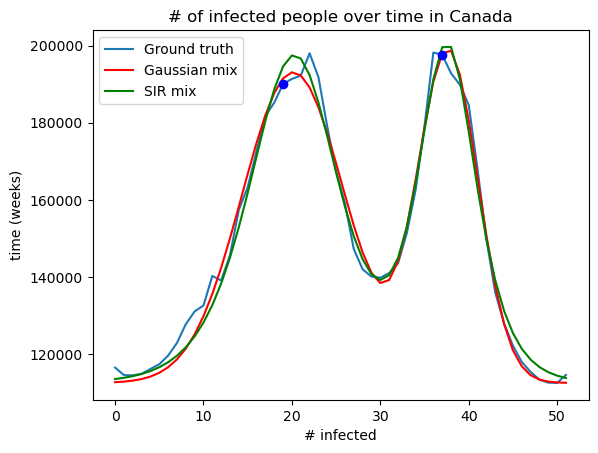

In [11]:
#Params_dict['Canada']
# get the plot
I = data[1][1:]
compare_plots(I,country)

In [56]:
pred_results = predictions(data)
# print(pred_results)

Analyzing data up to the observation 5

3
4
[1. 1. 1.]

 Predicting on region  Canada 


 Weeks in advance 1
Beta, Gamma
0.03737338517266987 0.030922665794325177
Prediction model
4776.0
Real cases:  127856
Mixed cases:  4776.0
MAPE 0.9626454761606807

 Weeks in advance 2
Beta, Gamma
0.03737343492019632 0.030922672997255474
Prediction model
4776.0
Real cases:  131145
Mixed cases:  4776.0
MAPE 0.9635822944069541

 Weeks in advance 3
Beta, Gamma
0.03737345428783196 0.03092267660237693
Prediction model
4776.0
Real cases:  132679
Mixed cases:  4776.0
MAPE 0.9640033464225688

 Weeks in advance 4
Beta, Gamma
0.03737343032011915 0.030922672140216982
Prediction model
4776.0
Real cases:  140331
Mixed cases:  4776.0
MAPE 0.9659661799602368
Analyzing data up to the observation 6

3
4
5
[1. 1. 1.]

 Predicting on region  Canada 


 Weeks in advance 1
Beta, Gamma
0.0413998660942254 0.03289118837081651
Prediction model
5424.0
Real cases:  131145
Mixed cases:  5424.0
MAPE 0.9586411986732243

 Weeks in

Prediction 1 weeks ahead
MAPE SIR Mix
(91.26472642298886, 1.8258031657075782)
Prediction 2 weeks ahead
MAPE SIR Mix
(inf, nan)
Prediction 3 weeks ahead
MAPE SIR Mix
(inf, nan)
Prediction 4 weeks ahead
MAPE SIR Mix
(inf, nan)


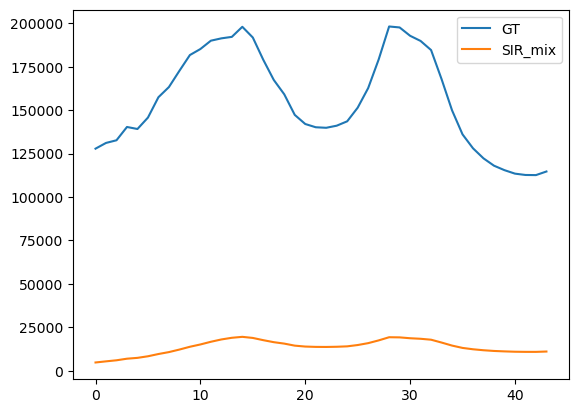

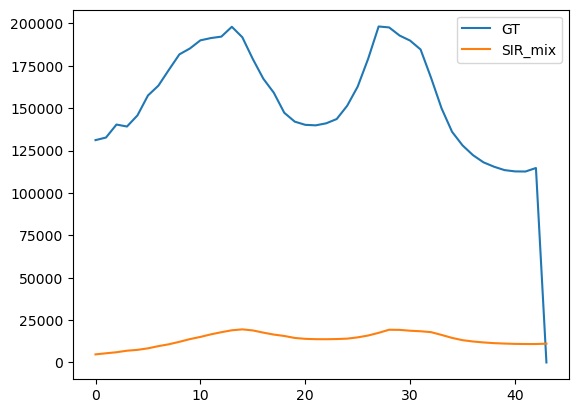

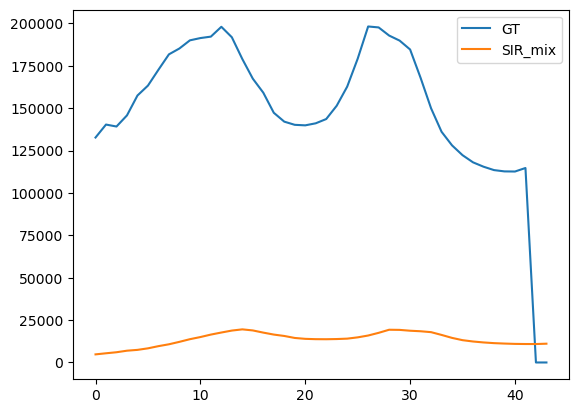

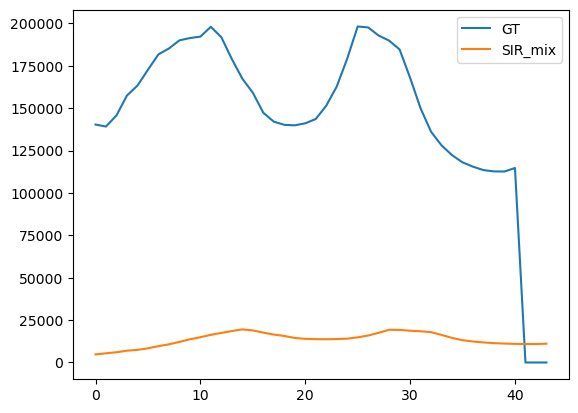

In [59]:
#visualize_pred(pred_results)
visualize_predictions(pred_results, country)